# Notebook for processing IMERG Rainfall data in Blob

This notebook is used to process the rainfall data on Blob for each cyclone since 2000. It extracts the daily on-land rainfall values from -2 days to +5 days to landfall in a 250km radius around the landfall location.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
import rioxarray as rxr
from azure.storage.blob import ContainerClient
import numpy as np
import warnings
from shapely.geometry import Point
from rasterio.features import geometry_mask
from scipy.interpolate import interp1d
from pyproj import CRS
from src import constants
from src.datasources import codab
import math
import matplotlib.pyplot as plt

load_dotenv()

False

In [ ]:
DEV_BLOB_SAS = os.getenv("DSCI_AZ_SAS_DEV")
DEV_BLOB_NAME = os.getenv("DEV_BLOB_NAME")
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
DEV_BLOB_PROJ_URL = DEV_BLOB_URL + "projects" + "?" + DEV_BLOB_SAS
GLOBAL_CONTAINER_NAME = "global"
DEV_BLOB_GLB_URL = DEV_BLOB_URL + GLOBAL_CONTAINER_NAME + "?" + DEV_BLOB_SAS

dev_glb_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

In [12]:
warnings.filterwarnings("ignore")

In [46]:
gdf_adm0 = codab.load_codab(admin_level=0)
# gdf_adm1 = codab.load_codab(admin_level=1)
# gdf_sel = gdf_adm1[
#    gdf_adm1["ADM1_PT"].isin(constants.ADMS)
# ]  # [gdf_adm1.ADM1_PT.isin(constants.ADMS)]
gdf_sel = gdf_adm0  # gdf_adm1[~gdf_adm1["ADM1_PT"].str.startswith("Maputo")]
ibtracs_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "glb"
    / "ibtracs"
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

# gdf_adm2 = codab.load_codab(admin_level=2)
# gdf_sel_adm2 = gdf_adm2[gdf_adm2.ADM1_PT.isin(constants.ADMS)]

minx, miny, maxx, maxy = gdf_sel.total_bounds

In [47]:
# blob_names = existing_files = [
#    x.name for x in dev_glb_container_client.list_blobs(name_starts_with="imerg/v6/")
# ]

In [48]:
gdf_ibtracs = gpd.read_file(ibtracs_path)

In [52]:
# Apply a 50km buffer (50,000 meters)
gdf_sel = gdf_sel.to_crs(f"EPSG:{constants.mdg_epsg}")
buffered_geometry = gdf_sel.buffer(100 * 1000)

# Convert the buffered geometry back to a GeoDataFrame
gdf_adm_sel_buff = gpd.GeoDataFrame(gdf_sel.copy(), geometry=buffered_geometry)

# Reproject back to the original CRS if needed
gdf_adm_sel_buff = gdf_adm_sel_buff.to_crs(gdf_adm0.crs)
# also making sure to take one time step before landfall since some storms even off shore can cause a lot of rain
gdf_ibtracs_time = gdf_ibtracs[gdf_ibtracs["ISO_TIME"] >= "2000-01-01"]
# which cyclones made landfall or came close by around 100km to land
landfall_cyclones = gpd.sjoin(
    gdf_ibtracs_time, gdf_adm_sel_buff, how="inner", predicate="intersects"
)["NAME"].unique()

<Axes: >

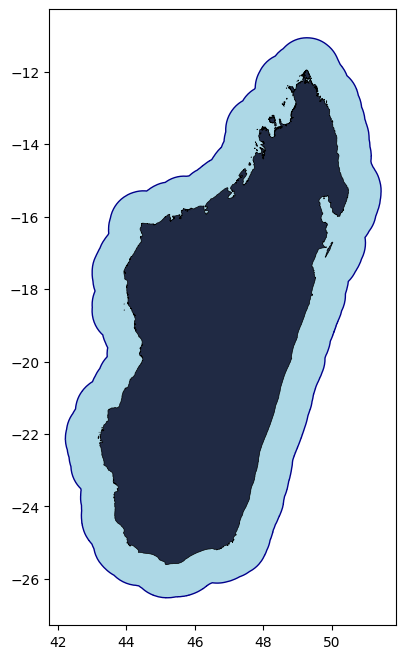

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot background admin areas (assuming adm and adm0 GeoDataFrames are available)
gdf_adm_sel_buff.plot(ax=ax, color="lightblue", edgecolor="darkblue")
gdf_adm0.plot(ax=ax, color="#202A44", edgecolor="black", linewidth=0.5)

In [54]:
landfall_cyclones

array(['ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH', 'DERA', 'CYPRIEN',
       'GUILLAUME', 'HARY', 'KESINY', 'ATANG', 'DELFINA', 'FARI',
       'JAPHET', 'MANOU', 'CELA', 'ELITA', 'GAFILO', 'BENTOJANA',
       'ERNEST', 'FELAPI', 'BOLOETSE', 'UNNAMED', 'BONDO', 'CLOVIS',
       'ENOK', 'FAVIO', 'INDLALA', 'JAYA', 'FAME', 'IVAN', 'JOKWE',
       'ASMA', 'ERIC', 'FANELE', 'IZILDA', 'JADE', 'BONGANI', 'DAVID',
       'FAMI', 'HUBERT', 'JOEL', 'BINGIZA', 'CHANDA', 'DANDO', 'GIOVANNA',
       'IRINA', 'ANAIS', 'HARUNA', 'DELIWE', 'HELLEN', 'CHEDZA', 'FUNDI',
       'HALIBA', 'ABELA', 'ENAWO', 'AVA', 'ELIAKIM', 'IDAI', 'BELNA',
       'DIANE', 'FRANCISCO', 'HEROLD', 'CHALANE', 'ELOISE', 'IMAN', 'ANA',
       'BATSIRAI', 'DUMAKO', 'EMNATI', 'GOMBE', 'JASMINE', 'CHENESO',
       'FREDDY', 'ALVARO', 'GAMANE'], dtype=object)

To run this code, create a new PROD BLOB SAS as it expires daily.

In [ ]:
PROD_BLOB_SAS = os.getenv("PROD_BLOB_SAS")
PROD_BLOB_NAME = os.getenv("PROD_BLOB_NAME")

In [188]:
combined_df = []
landfall_locs = []
# dates = pd.date_range(start="2003-03-11", periods=len(das), freq="D")
radii = list(range(50, 501, 50))
radii = [250]

In [ ]:
for cyc in landfall_cyclones:
    if cyc == "UNNAMED":
        continue

    cyc_df = gdf_ibtracs_time[gdf_ibtracs_time["NAME"] == cyc]

    # Convert ISO_TIME to datetime and set as index
    cyc_df["ISO_TIME"] = pd.to_datetime(cyc_df["ISO_TIME"])
    cyc_df.set_index("ISO_TIME", inplace=True)

    # Resample the DataFrame to the desired frequency
    cyc_df = cyc_df.resample("30T").asfreq()

    # Interpolate numerical columns and forward fill text columns
    for column in cyc_df.columns:
        if pd.api.types.is_numeric_dtype(cyc_df[column]):
            non_nan = cyc_df[column].dropna()
            if len(non_nan) > 1:
                interp_func = interp1d(
                    non_nan.index.astype(np.int64),
                    non_nan.values,
                    kind="linear",
                    fill_value="extrapolate",
                )
                cyc_df[column] = interp_func(cyc_df.index.astype(np.int64))
        else:
            cyc_df[column] = cyc_df[column].ffill()

    # Reset index
    cyc_df.reset_index(inplace=True)
    cyc_df["geometry"] = cyc_df.apply(
        lambda row: Point(row["LON"], row["LAT"]), axis=1
    )
    cyc_df = gpd.GeoDataFrame(cyc_df, geometry="geometry")

    # Calculate distances to the polygon (ADM0 boundary)
    cyc_df["distance_to_country"] = cyc_df.geometry.apply(
        lambda point: point.distance(gdf_adm0.geometry)
    )

    # Determine the first landfall point based on minimum distance
    landfall_point = cyc_df.loc[[cyc_df["distance_to_country"].idxmin()]]

    # Store the first landfall point in the landfall_df
    # landfall_df = pd.DataFrame(
    #    {
    #        "storm": [cyc],
    #        "landfall_lon": [landfall_point["LON"]],
    #        "landfall_lat": [landfall_point["LAT"]],
    #        "landfall_time": [landfall_point["ISO_TIME"]],
    #    }
    # )

    landfall_locs.append(landfall_point)

    print(f"First landfall for {cyc} at {landfall_point['ISO_TIME'].iloc[0]}")
    landfall_time = landfall_point["ISO_TIME"].iloc[0]
    lf_dt = landfall_point

    # Iterate over each date and radius
    storm_df_list = []
    for time_step in range(-1, 2):
        date = landfall_time + pd.Timedelta(days=time_step)
        target_date = date.normalize()
        blob_name = f"imerg/v7/late/processed/imerg-daily-late-{target_date.strftime('%Y-%m-%d')}.tif"
        cog_url = f"https://{PROD_BLOB_NAME}.blob.core.windows.net/raster/{blob_name}?{PROD_BLOB_SAS}"

        try:
            da_in = rxr.open_rasterio(cog_url, masked=True)
            da_in = da_in.persist()
            if da_in.rio.crs is None:
                da_in.rio.write_crs("EPSG:4326", inplace=True)
        except Exception as e:
            da_in = None

        if da_in is not None:
            for radius in radii:
                # Create a GeoDataFrame for the landfall point with the buffer
                gdf_lf = gpd.GeoDataFrame(
                    {
                        "geometry": [
                            Point(
                                lf_dt["LON"].values[0],
                                lf_dt["LAT"].values[0],
                            ),
                        ]
                    },
                    crs=CRS("EPSG:4326"),
                )

                # Reprojecting the GeoDataFrame to a local CRS for Mozambique (South Africa Albers)
                gdf_lf = gdf_lf.to_crs(f"EPSG:{constants.mdg_epsg}")

                # Create buffer in meters
                gdf_lf["geometry"] = gdf_lf.buffer(
                    radius * 1000
                )  # Buffer radius in meters
                gdf_lf = gdf_lf.to_crs(
                    "EPSG:4326"
                )  # Reproject back to EPSG:4326

                # Perform spatial intersection with the country (gdf_sel)
                gdf_lf_intersection = gpd.overlay(
                    gdf_lf, gdf_adm0, how="intersection"
                )
                if gdf_lf_intersection.shape[0] == 0:
                    print("No intersection of radius with country. Skipping:")
                    storm_df_list.append(
                        {
                            "storm": cyc,  # Storm name/identifier
                            "date": date,  # Date of the event
                            "time_step": time_step,  # Time step of the data
                            "radius": radius,  # Radius of the buffer
                            "country": country["ADM0_EN"],  # country name
                            "median_precip": np.nan,  # Median precipitation value
                        }
                    )
                    continue

                # Initialize a list to store the results
                storm_df_list = []

                # Check if there's any intersection
                # Iterate through each country in the clipped GeoDataFrame (gdf_lf_intersection)
                for (
                    idx,
                    country,
                ) in gdf_lf_intersection.iterrows():
                    # Extract the geometry of the country
                    country_geom = country.geometry

                    # Create a mask based on the country geometry
                    mask = geometry_mask(
                        [country_geom],
                        transform=da_in.rio.transform(),
                        invert=True,  # Mask the areas outside the country
                        out_shape=da_in.rio.shape,
                    )

                    # Apply the mask to the raster (da_in is the raster data)
                    masked_da = da_in.where(mask)

                    # Extract the values of the masked raster (non-NaN values)
                    values = masked_da.values[~np.isnan(masked_da.values)]

                    # Compute the median value for the country
                    median_value = (
                        np.median(values) if values.size > 0 else np.nan
                    )

                    # Append the results to the list
                    storm_df_list.append(
                        {
                            "storm": cyc,  # Storm name/identifier
                            "date": date,  # Date of the event
                            "time_step": time_step,  # Time step of the data
                            "radius": radius,  # Radius of the buffer
                            "country": country["ADM0_EN"],  # country name
                            "median_precip": median_value,  # Median precipitation value
                        }
                    )

        # Create DataFrame from storm_df_list
        storm_df = pd.DataFrame(storm_df_list)
        combined_df.append(storm_df)

First landfall for HEROLD at 2020-03-14 03:00:00


<Axes: title={'center': 'AOI for Herold'}>

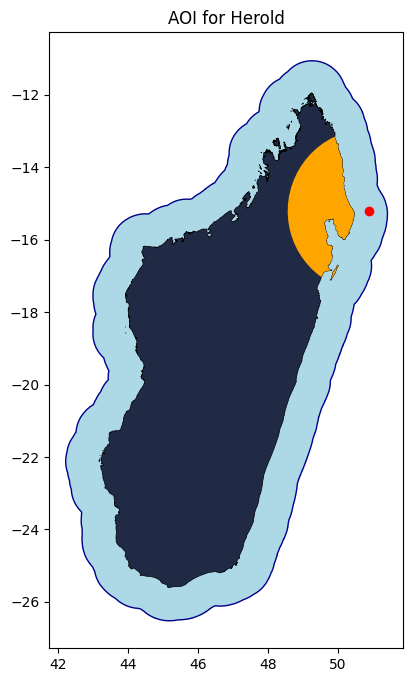

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot background admin areas (assuming adm and adm0 GeoDataFrames are available)
gdf_adm_sel_buff.plot(ax=ax, color="lightblue", edgecolor="darkblue")
gdf_adm0.plot(ax=ax, color="#202A44", edgecolor="black", linewidth=0.5)
gdf_lf_intersection.plot(ax=ax, color="orange")
plt.title("AOI for Herold")
landfall_point.plot(ax=ax, color="red")

In [190]:
# Combine all DataFrames into a single DataFrame
rain_df = pd.concat(combined_df, ignore_index=True)
landfall_df = pd.concat(landfall_locs, ignore_index=True)

In [191]:
rain_df

,storm,date,time_step,radius,country,median_precip
0,DERA,2001-03-04 22:30:00,-1,250,Madagascar,0.040000
1,DERA,2001-03-05 22:30:00,0,250,Madagascar,5.880000
2,DERA,2001-03-06 22:30:00,1,250,Madagascar,6.495001
3,CYPRIEN,2002-01-01 05:30:00,-1,250,Madagascar,45.642494
4,CYPRIEN,2002-01-02 05:30:00,0,250,Madagascar,21.469997
...,...,...,...,...,...,...
205,ALVARO,2024-01-01 16:30:00,0,250,Madagascar,84.150002
206,ALVARO,2024-01-02 16:30:00,1,250,Madagascar,1.560000
207,GAMANE,2024-03-26 02:30:00,-1,250,Madagascar,50.595001
208,GAMANE,2024-03-27 02:30:00,0,250,Madagascar,125.075020


In [198]:
rain_df.to_csv(
    Path(constants.AA_DATA_DIR)
    / "public"
    / "processed"
    / "mdg"
    / "daily_imerg_cyclone_landfall_fixed_adm0_v7.csv"
)
landfall_df.to_csv(
    Path(constants.AA_DATA_DIR)
    / "public"
    / "processed"
    / "mdg"
    / "landfall_time_location_fixed_adm0_v7.csv"
)